# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



Opis działania: 

każdy na początku wykonał powyższe zadania samodzielnie, wymieniliśmy się własnymi kodami, by przejrzeć kod współpracownika, znaleźć potencjalne problemy oraz lepsze od swoich rozwiązania w celu późniejszego scalenia kodu wybierając jedynie lepsze fragmenty po naniesionych ewentualnych poprawkach. 

Ostateczny postać kodu:

Zadanie 1 - Szymon 
Zadania 2 - 4 Martyna 

In [1]:
import pandas as pd
import requests
import zipfile
import io, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:


# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582', 'meta': '584'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj

    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
            return None
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df

# Przykladowe użycie
#df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

#funkcja do ściągania meta danych - modyfikacja funkcji do ściągania archiwum - bez obsługiwania plików .zip
def download_meta_data(gios_id):
  url = f"{gios_archive_url}{gios_id}"
  response = requests.get(url)
  response.raise_for_status()
  with io.BytesIO(response.content) as f:
    try:
      df_meta = pd.read_excel(f, header=0)
    except  Exception as e:
      print(f"Błąd przy wczytywaniu metadanych: {e}")
  return df_meta

In [3]:
df_meta = download_meta_data(gios_url_ids['meta'])

In [4]:
df_2014 = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])

/home/szymon/.local/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [5]:
df_2019 = download_gios_archive(2019, gios_url_ids[2019], gios_pm25_file[2019])


In [6]:
df_2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

Na początku zrobimy przegląd kilku początkowych wierwszy z każdego roku, by naocznie sprawdzić jak wyglądają dane. Pierwsze wiersze często też kryją znaczące informacje, kluczowe dla zrozumienia danych.

In [7]:
df_2024.head(10)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,Nr,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
1,Kod stacji,DsChojnowMalMOB,DsJelGorOgin,DsKlodzSzkol,DsKudowaSzkoMOB,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpNaklWawrzy,...,WmElkStadion,WmOlsPuszkin,WpKaliSawick,WpKoscianMayMOB,WpPoznDabrow,WpPoznSzwajc,ZpDabkiSztorMOB,ZpKolZolkiew,ZpSzczAndrze,ZpSzczPilsud
2,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
3,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
4,Jednostka,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3
5,Kod stanowiska,DsChojnowMalMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsKlodzSzkol-PM2.5-1g,DsKudowaSzkoMOB-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpBydWarszaw-PM2.5-1g,KpNaklWawrzy-PM2.5-1g,...,WmElkStadion-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,WpKoscianMayMOB-PM2.5-1g,WpPoznDabrow-PM2.5-1g,WpPoznSzwajc-PM2.5-1g,ZpDabkiSztorMOB-PM2.5-1g,ZpKolZolkiew-PM2.5-1g,ZpSzczAndrze-PM2.5-1g,ZpSzczPilsud-PM2.5-1g
6,2024-01-01 01:00:00,NaN,30.8,53.5,NaN,94,58.3,28.5,110.9,96.8,...,48.6,37.4,69.9,90.2,41.3,67.9,26.5,63.9,49.9,57.6
7,2024-01-01 02:00:00,NaN,30.2,61.3,NaN,44.8,44.8,73.9,39.5,37,...,12.8,18.8,57.1,55.4,38.4,88.7,26.8,33.5,15.4,24.6
8,2024-01-01 03:00:00,NaN,22.4,56.1,NaN,20.2,30.5,66.5,39.6,43.6,...,11,19,56,46.1,25.8,84.6,24.9,32.9,14.3,21.7
9,2024-01-01 04:00:00,NaN,11.2,27.6,NaN,14.7,18.5,66.8,36.2,42.6,...,10,18.7,44.1,26.9,16.3,75.8,26.4,32.6,17,20.1


In [8]:
df_2019.head(10)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,Nr,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,Kod stacji,DsDusznikMOB,DsJaworMOB,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpMogiNowMOB,KpToruDziewu,KpWloclOkrze,...,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmElbBazynsk,WmGoldUzdrowMOB,WmOlsPuszkin,WpKaliSawick,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczPils02
2,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
3,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
4,Jednostka,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3
5,Kod stanowiska,DsDusznikMOB-PM2.5-1g,DsJaworMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpMogiNowMOB-PM2.5-1g,KpToruDziewu-PM2.5-1g,KpWloclOkrze-PM2.5-1g,...,SlBielPartyz-PM2.5-1g,SlKatoKossut-PM2.5-1g,SlZlotPotLes-PM2.5-1g,WmElbBazynsk-PM2.5-1g,WmGoldUzdrowMOB-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,ZpSzczAndr01-PM2.5-1g,ZpSzczBudzWosMOB-PM2.5-1g,ZpSzczPils02-PM2.5-1g
6,2019-01-01 01:00:00,33.4053,51.3878,118.773,102.09,107.061,64.1177,NaN,24.003,51.317,...,110.199,76.7306,26.3444,34.3706,14.9449,40.9183,75.2,NaN,NaN,73.935
7,2019-01-01 02:00:00,13.8028,28.4995,110.064,63.6111,55.9187,43.8401,NaN,33.6542,30.698,...,73.4132,54.4664,19.0619,23.1494,10.742,25.9358,47.9076,NaN,NaN,11.7883
8,2019-01-01 03:00:00,9.94056,11.1206,107.941,48.354,41.3488,22.8383,NaN,13.603,28.262,...,50.2355,50.4599,43.7717,21.0711,12.0391,24.5725,22.8309,5.57095,NaN,8.69917
9,2019-01-01 04:00:00,6.75889,5.57358,94.5489,34.6621,29.8697,20.1829,NaN,17.4302,26.522,...,37.5872,34.809,64.0139,21.1671,13.1849,20.6336,20.59,5.77369,NaN,5.96861


In [9]:
df_2014.head(10)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,Kod stacji,DsWrocWisA,KpAirpWiktorowo,KpBydgPlPozn,KpBydgWarszawska,KpTorunDziewulsk,LdLodzWIOSACzernik,LdZgierzWIOSAMielcza,LuZgoraWIOS_AUT,MpKrakowWIOSAKra6117,...,SkMalogCemen3,SkPolanRuszcz,SlGliwiGliw_mewy,SlKatowKato_kossu,SlZlotyJano_lesni,WmOlsztyWIOS_Puszkin,WpWKP001,WpWKPKalisz007/10,ZpSzczecin001,ZpSzczecin002
1,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
2,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
3,2014-01-01 01:00:00,152,104.56,116.214424,140.857376,52.4172,81.029259,119.696114,NaN,104,...,34.12,56.54,188,104,32,84.121582,56.1,NaN,105.489,109
4,2014-01-01 02:00:00,137,94.3,NaN,121.629723,NaN,210.36467,70.337502,NaN,104,...,34.61,35.93,130,107,39,75.444382,55.2,82.5,149.797,118
5,2014-01-01 03:00:00,129,102.48,NaN,59.189041,46.5652,66.425789,40.915695,NaN,91,...,33.58,34.36,138,114,43,34.427513,49.9,83,86.9602,120
6,2014-01-01 04:00:00,129,102.32,NaN,58.038334,45.8128,53.999668,37.817917,NaN,89,...,31.37,35.21,171,108,42,32.742474,52,73.1,74.8762,104
7,2014-01-01 05:00:00,105,88.73,NaN,59.658134,45.8128,52.23967,38.814861,NaN,83,...,32.27,35.54,163,88,40,32.714367,63.4,74.9,61.9866,96
8,2014-01-01 06:00:00,92,83.68,NaN,58.109863,44.4752,56.738743,40.452362,NaN,81,...,32.28,34.78,152,77,45,29.906473,61.8,77.4,51.5138,87
9,2014-01-01 07:00:00,92,93.46,62.139446,56.460609,43.5556,54.783894,40.300835,NaN,77,...,31.87,33.03,126,85,46,28.310535,53.2,80.8,58.7642,78


Powyżej, zauważyć możemy, że niektórych wierwszy nie było w roku 2014 jak "Numer", czy "Jednostka". Wiersze "Czas uśredniania" i "Wskaźnik", wydają się mieć mnóstwo powtórzonych komórek. Sprawdzimy, czy tak jest rzeczywiście.

In [10]:
print("-"*100)
print(df_2024.loc[0].unique())
print(df_2024.loc[2].unique())
print(df_2024.loc[3].unique())
print(df_2024.loc[4].unique())
print("-"*100)
print(df_2019.loc[0].unique())
print(df_2019.loc[2].unique())
print(df_2019.loc[3].unique())
print(df_2019.iloc[4].unique())
print("-"*100)
print(df_2014.loc[1].unique())
print(df_2014.iloc[2].unique())

----------------------------------------------------------------------------------------------------
['Nr' 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
['Wskaźnik' 'PM2.5']
['Czas uśredniania' '1g']
['Jednostka' 'ug/m3']
----------------------------------------------------------------------------------------------------
['Nr' 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63]
['Wskaźnik' 'PM2.5']
['Czas uśredniania' '1g']
['Jednostka' 'ug/m3']
----------------------------------------------------------------------------------------------------
['Wskaźnik' 'PM2.5']
['Czas uśredniania' '1g']


Jak widzimy powyżej, wiersze "Wskaźnik", "Jednostka", "Czas uśredniania" zawierają jedynie jedynie jedną unikalną wartość (oczywiście poza wartością z nazwą danego wiersza - podczas pobierania danych nie zmieniliśmy indeksowania na pierwszą kolumnę, głównie, by nie mieć problemów z innymi danymi i ewentualnym wpisywaniem długich nazw)
Poniżej sprawdzimy, czy są inne wierwsze, które się w całości powtarzają.


In [11]:
df_compare_1 = df_2024.merge(df_2019, how="outer", indicator=True)
df_compare_2 = df_2024.merge(df_2014, how="outer", indicator=True)
df_compare_3 = df_2014.merge(df_2019, how="outer", indicator=True)

In [12]:
df_compare_1[df_compare_1["_merge"] == "both"]

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,_merge
17544,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,both
17545,Jednostka,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,both
17550,Nr,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,both
17551,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,both


In [13]:
df_compare_2[df_compare_2["_merge"] == "both"]

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,_merge
17544,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,both
17550,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,both


In [14]:
df_compare_3[df_compare_3["_merge"] == "both"]

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,_merge
17520,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,both
17526,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,both


Jak możemy zauważyć powyżej wiersze "Czas uśredniania", "Jednostka", "Nr", "Wskaźnik" mają mnóstwo powtórzonych danych, które dla nas nie będą informatywne, zatem pozbędziemy się nich przed dalszą analizą.

In [15]:
df_2014 = df_2014.drop(index=[1,2])
df_2019 = df_2019.drop(index=[0,2,3,4])
df_2024 = df_2024.drop(index=[0,2,3,4])

In [16]:
df_2014.head(5)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,Kod stacji,DsWrocWisA,KpAirpWiktorowo,KpBydgPlPozn,KpBydgWarszawska,KpTorunDziewulsk,LdLodzWIOSACzernik,LdZgierzWIOSAMielcza,LuZgoraWIOS_AUT,MpKrakowWIOSAKra6117,...,SkMalogCemen3,SkPolanRuszcz,SlGliwiGliw_mewy,SlKatowKato_kossu,SlZlotyJano_lesni,WmOlsztyWIOS_Puszkin,WpWKP001,WpWKPKalisz007/10,ZpSzczecin001,ZpSzczecin002
3,2014-01-01 01:00:00,152,104.56,116.214424,140.857376,52.4172,81.029259,119.696114,NaN,104,...,34.12,56.54,188,104,32,84.121582,56.1,NaN,105.489,109
4,2014-01-01 02:00:00,137,94.3,NaN,121.629723,NaN,210.36467,70.337502,NaN,104,...,34.61,35.93,130,107,39,75.444382,55.2,82.5,149.797,118
5,2014-01-01 03:00:00,129,102.48,NaN,59.189041,46.5652,66.425789,40.915695,NaN,91,...,33.58,34.36,138,114,43,34.427513,49.9,83,86.9602,120
6,2014-01-01 04:00:00,129,102.32,NaN,58.038334,45.8128,53.999668,37.817917,NaN,89,...,31.37,35.21,171,108,42,32.742474,52,73.1,74.8762,104


In [17]:
df_2019.head(5)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,Kod stacji,DsDusznikMOB,DsJaworMOB,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpMogiNowMOB,KpToruDziewu,KpWloclOkrze,...,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmElbBazynsk,WmGoldUzdrowMOB,WmOlsPuszkin,WpKaliSawick,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczPils02
5,Kod stanowiska,DsDusznikMOB-PM2.5-1g,DsJaworMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpMogiNowMOB-PM2.5-1g,KpToruDziewu-PM2.5-1g,KpWloclOkrze-PM2.5-1g,...,SlBielPartyz-PM2.5-1g,SlKatoKossut-PM2.5-1g,SlZlotPotLes-PM2.5-1g,WmElbBazynsk-PM2.5-1g,WmGoldUzdrowMOB-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,ZpSzczAndr01-PM2.5-1g,ZpSzczBudzWosMOB-PM2.5-1g,ZpSzczPils02-PM2.5-1g
6,2019-01-01 01:00:00,33.4053,51.3878,118.773,102.09,107.061,64.1177,NaN,24.003,51.317,...,110.199,76.7306,26.3444,34.3706,14.9449,40.9183,75.2,NaN,NaN,73.935
7,2019-01-01 02:00:00,13.8028,28.4995,110.064,63.6111,55.9187,43.8401,NaN,33.6542,30.698,...,73.4132,54.4664,19.0619,23.1494,10.742,25.9358,47.9076,NaN,NaN,11.7883
8,2019-01-01 03:00:00,9.94056,11.1206,107.941,48.354,41.3488,22.8383,NaN,13.603,28.262,...,50.2355,50.4599,43.7717,21.0711,12.0391,24.5725,22.8309,5.57095,NaN,8.69917


In [18]:
df_2024.head(5)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
1,Kod stacji,DsChojnowMalMOB,DsJelGorOgin,DsKlodzSzkol,DsKudowaSzkoMOB,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpNaklWawrzy,...,WmElkStadion,WmOlsPuszkin,WpKaliSawick,WpKoscianMayMOB,WpPoznDabrow,WpPoznSzwajc,ZpDabkiSztorMOB,ZpKolZolkiew,ZpSzczAndrze,ZpSzczPilsud
5,Kod stanowiska,DsChojnowMalMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsKlodzSzkol-PM2.5-1g,DsKudowaSzkoMOB-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpBydWarszaw-PM2.5-1g,KpNaklWawrzy-PM2.5-1g,...,WmElkStadion-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,WpKoscianMayMOB-PM2.5-1g,WpPoznDabrow-PM2.5-1g,WpPoznSzwajc-PM2.5-1g,ZpDabkiSztorMOB-PM2.5-1g,ZpKolZolkiew-PM2.5-1g,ZpSzczAndrze-PM2.5-1g,ZpSzczPilsud-PM2.5-1g
6,2024-01-01 01:00:00,NaN,30.8,53.5,NaN,94,58.3,28.5,110.9,96.8,...,48.6,37.4,69.9,90.2,41.3,67.9,26.5,63.9,49.9,57.6
7,2024-01-01 02:00:00,NaN,30.2,61.3,NaN,44.8,44.8,73.9,39.5,37,...,12.8,18.8,57.1,55.4,38.4,88.7,26.8,33.5,15.4,24.6
8,2024-01-01 03:00:00,NaN,22.4,56.1,NaN,20.2,30.5,66.5,39.6,43.6,...,11,19,56,46.1,25.8,84.6,24.9,32.9,14.3,21.7


Zauważmy, że w 2019 i 2024 pojawiły się też wiersze "Kod stanowiska", które bardzo przypominają "Kod stacji". Sprawdźmy, czy ta intuicja się sprawdza.

In [19]:
# data frame stworzony z dwóch kolumn - jedna zawiera pierwszy fragment napisu z komórek "Kod stanowiska", druga cały "Kod stacji"
duplicates1 = pd.DataFrame({
    0: df_2024.iloc[1, 1:].astype(str).str.split('-').str[0],
    1: df_2024.iloc[0, 1:]
})
mask1 = duplicates1[0] != duplicates1[1]
df_diff = duplicates1[mask1]
print(df_diff)

                  0                 1
22  LuLubsStrzelMOB  LuLubsStrzelMOB 


In [20]:
duplicates2 = pd.DataFrame({
    0: df_2019.iloc[1, 1:].astype(str).str.split('-').str[0],
    1: df_2019.iloc[0, 1:]
})
mask2 = duplicates2[0] != duplicates2[1]
df_diff = duplicates2[mask2]
print(df_diff)

Empty DataFrame
Columns: [0, 1]
Index: []


Zatem możemy założyć, że "Kod stanowiska" jest również wierwszym nieinformatywnym, zatem się go pozbędziemy.

In [21]:
df_2019 = df_2019.drop(index=[5])
df_2024 = df_2024.drop(index=[5])

In [22]:
df_2019.head(5)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,Kod stacji,DsDusznikMOB,DsJaworMOB,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpMogiNowMOB,KpToruDziewu,KpWloclOkrze,...,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmElbBazynsk,WmGoldUzdrowMOB,WmOlsPuszkin,WpKaliSawick,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczPils02
6,2019-01-01 01:00:00,33.4053,51.3878,118.773,102.09,107.061,64.1177,NaN,24.003,51.317,...,110.199,76.7306,26.3444,34.3706,14.9449,40.9183,75.2,NaN,NaN,73.935
7,2019-01-01 02:00:00,13.8028,28.4995,110.064,63.6111,55.9187,43.8401,NaN,33.6542,30.698,...,73.4132,54.4664,19.0619,23.1494,10.742,25.9358,47.9076,NaN,NaN,11.7883
8,2019-01-01 03:00:00,9.94056,11.1206,107.941,48.354,41.3488,22.8383,NaN,13.603,28.262,...,50.2355,50.4599,43.7717,21.0711,12.0391,24.5725,22.8309,5.57095,NaN,8.69917
9,2019-01-01 04:00:00,6.75889,5.57358,94.5489,34.6621,29.8697,20.1829,NaN,17.4302,26.522,...,37.5872,34.809,64.0139,21.1671,13.1849,20.6336,20.59,5.77369,NaN,5.96861


In [23]:
# Nasze df umieszczamy w tablicy, by można było łatwo po nich iterować (należy pamiętać, że jest to kopia df, a nie odnośniki do niej)
data = [df_2014, df_2019, df_2024]
data_names = [2014, 2019, 2024]


Sprawdźmy jeszcze, czy wszystkie komórki liczbowe mają dobry format (to znaczy są rzeczywiście w typie liczbowym, a nie stringiem). Popularnym problemem jest zapisanie liczb z "," zamiast ".", co prowadzi do błędów w czasie przetwarzania danych. 

In [24]:
def normalize_mixed_numeric_column(series):
    s = series.copy()

    # Zamiana na string na czas obróbki (z zachowaniem NaN)
    s_str = s.astype(str).where(s.notna(), other=np.nan)

    # Zamiana przecinków na kropki
    s_str = s_str.str.replace(',', '.', regex=False)

    # Próba konwersji na liczbę
    s_num = pd.to_numeric(s_str, errors='coerce')

    # Warunek: konwersja się udała (True -> liczba, False -> brak)
    mask_numeric = s_num.notna()

    # Wynik końcowy
    result = np.where(mask_numeric, s_num, series)

    # Liczenie komórek, które zostały faktycznie zmienione
    changed = (mask_numeric & (s != s_num)).sum()

    # Zwracamy:
    # - przetworzoną serię
    # - liczbę zmian
    return pd.Series(result, index=series.index), changed

for i in range(len(data)):
    changes_total = 0
    for col in data[i].columns:
        data[i][col], changed = normalize_mixed_numeric_column(data[i][col])
        changes_total += changed
    
    print(f"Łączna liczba zamienionych komórek w {data_names[i]}:", changes_total)

Łączna liczba zamienionych komórek w 2014: 11
Łączna liczba zamienionych komórek w 2019: 0
Łączna liczba zamienionych komórek w 2024: 0


Po zredukowaniu danych do informatywnych wierszy i ujednoliceniu formatu, zaktualizujmy dane o metadane i dodajmy informacje na temat miejscowości. Przejrzyjmy kilka pierwszych wierszy data frame'u z metadanymi. 

In [25]:
df_meta.head()

,Nr,Kod stacji,Kod międzynarodowy,Nazwa stacji,Stary Kod stacji \n(o ile inny od aktualnego),Data uruchomienia,Data zamknięcia,Typ stacji,Typ obszaru,Rodzaj stacji,Województwo,Miejscowość,Adres,WGS84 φ N,WGS84 λ E
0,1,DsBialka,NaN,Białka,NaN,1990-01-03,2005-12-31,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,NaN,51.197783,16.117390
1,2,DsBielGrot,NaN,Bielawa - ul. Grota Roweckiego,NaN,1994-01-02,2003-12-31,tło,miejski,w budynku,DOLNOŚLĄSKIE,Bielawa,ul. Grota Roweckiego 6,50.682510,16.617348
2,3,DsBogatFrancMOB,PL0602A,Bogatynia Mobil,DsBogatMob,2015-01-01,2015-12-31,tło,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,ul. Francuska/Kręta,50.940998,14.916790
3,4,DsBogChop,PL0315A,Bogatynia - Chopina,NaN,1996-01-01,2013-12-31,przemysłowa,miejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Bogatynia,ul. Chopina 35,50.905856,14.967175
4,5,DsBogZatonieMob,PL0576A,Bogatynia - Mobil,NaN,2012-01-01,2012-12-31,przemysłowa,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,"ul. Konrada, Zatonie",50.943245,14.913327


Będą nas interesowały głównie kolumny "Kod stacji" (za jej pomocą połączymy dane z matadanych wraz z danymi z konkretnych lat), "Stary Kod stacji \n(o ile inny od aktualnego)", by móc zaktualizować kody w starszych plikach, "Miejscowość", by móc uzupełnić dane zgodnie z wymaganiami zadania. 
Zanim dodamy informacje o miejscowości usuniemy kolumny ze stacjami, które nie występują we wszystkich trzech latach. 

In [26]:
# Tworzymy mapowanie, rozdzielając ewentualne wielokrotne kody w kluczach
mapowanie = {}
for old, new in df_meta.set_index('Stary Kod stacji \n(o ile inny od aktualnego)')["Kod stacji"].dropna().items():
    # jeśli w kluczu są przecinki, rozdzielamy i dodajemy każdy osobno
    for part in str(old).split(','):
        mapowanie[part.strip()] = new

# Podmieniamy kody w pierwszym wierszu każdej ramki danych dopóki możemy coś podmienić (być może nazwa zmieniła się więcej niż jedne raz!) 
iteration = 0
rep = True

while rep == True:
    iteration += 1
    rep = False 
    for i in range(len(data)):
        # kopiujemy stare wartości, pomijając pierwszą kolumnę z nagłówkiem
        old_values = data[i].iloc[0, :].copy()
        
        # zamiana kodów, zapis do DataFrame
        data[i].iloc[0, :] = data[i].iloc[0, :].replace(mapowanie).values
        
        # liczymy ile kodów się zmieniło
        codes_changed = (old_values != data[i].iloc[0, :]).sum()
        if codes_changed != 0:
            rep = True 
        print(f"Iteracja: {iteration}")
        print(f"Liczba zamienionych kodów stacji w {data_names[i]}: {codes_changed}\n")

Iteracja: 1
Liczba zamienionych kodów stacji w 2014: 34

Iteracja: 1
Liczba zamienionych kodów stacji w 2019: 7

Iteracja: 1
Liczba zamienionych kodów stacji w 2024: 0

Iteracja: 2
Liczba zamienionych kodów stacji w 2014: 1

Iteracja: 2
Liczba zamienionych kodów stacji w 2019: 0

Iteracja: 2
Liczba zamienionych kodów stacji w 2024: 0

Iteracja: 3
Liczba zamienionych kodów stacji w 2014: 0

Iteracja: 3
Liczba zamienionych kodów stacji w 2019: 0

Iteracja: 3
Liczba zamienionych kodów stacji w 2024: 0



In [27]:
# stacje wspólne
# wykorzystujemy tu, że kolumna "Kod stacji" wraz z datami występuje w każdym analizowanym roku
stacje_2014 = set(data[0].iloc[0, :])
stacje_2019 = set(data[1].iloc[0, :])
stacje_2024 = set(data[2].iloc[0, :])

stacje_wspolne = stacje_2014 & stacje_2019 & stacje_2024

# filtrujemy kolumny, zostawiając tylko wspólne stacje
for i in range(len(data)):
    before = data[i].shape[1]  # liczba kolumn przed filtrowaniem
    data[i] = data[i][data[i].columns[data[i].iloc[0, :].isin(stacje_wspolne)]]
    after = data[i].shape[1]   # liczba kolumn po filtrowaniu
    print(f"Usunięto w {data_names[i]} {before-after-1} stacji")

print(f"Liczba stacji wspólnych we wszystkich latach: {len(stacje_wspolne)}")

Usunięto w 2014 10 stacji
Usunięto w 2019 38 stacji
Usunięto w 2024 71 stacji
Liczba stacji wspólnych we wszystkich latach: 25


In [28]:
# Tworzymy słownik: kod stacji -> miasto
stacje_miasta = df_meta.set_index('Kod stacji')['Miejscowość'].dropna().to_dict()

for i in range(len(data)):
    # Pobieramy kody stacji z pierwszego wiersza (pomijamy pierwszą kolumnę)
    kody = data[i].iloc[0, 1:].tolist()
    
    # Pobieramy odpowiadające miasta
    miasta = [stacje_miasta.get(kod, '') for kod in kody]
    
    # Tworzymy MultiIndex
    multi_idx = pd.MultiIndex.from_tuples(
        list(zip(kody, miasta)),
        names=['Kod stacji', 'Miejscowość']
    )
    
    # Dane bez pierwszego wiersza (kody stacji) i pierwszej kolumny 
    df_values = data[i].iloc[1:, 1:].values
    
    # Tworzymy nowy DataFrame z MultiIndex
    new_df = pd.DataFrame(df_values, columns=multi_idx)
    
    # Wstawiamy pierwszą kolumnę z oryginalnego DataFrame 
    new_df.insert(0, data[i].iloc[:, 0].name, data[i].iloc[1:, 0].values)
    
    # Zastępujemy oryginalny DataFrame
    data[i] = new_df
    
    # Liczymy ile miast udało się dopasować
    dopasowane = sum(1 for m in miasta if m != '')
    print(f"W {data_names[i]} dopasowano {dopasowane}/{len(miasta)} miast")

W 2014 dopasowano 24/24 miast
W 2019 dopasowano 24/24 miast
W 2024 dopasowano 24/24 miast


In [29]:
df_2014 = data[0]
df_2019 = data[1]
df_2024 = data[2]

In [30]:
# Łączymy wszystkie DataFrame w jeden
combined_df = pd.concat(data, ignore_index=True)

In [31]:
combined_df.tail()

Kod stacji,0,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,...,OpKKozBSmial,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
Miejscowość,,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,...,Kędzierzyn-Koźle,Białystok,Przemyśl,Gdańsk,Katowice,Złoty Potok,Olsztyn,Kalisz,Szczecin,Szczecin
26299,2024-12-31 20:00:00,51.4,5.4,33.3,49.5,15.9,57.0,43.2,22.2,33.0,...,18.6,10.0,19.7,11.2,20.3,23.8,16.0,25.4,8.4,14.0
26300,2024-12-31 21:00:00,65.5,7.7,34.0,48.7,16.1,58.7,54.1,34.5,29.4,...,22.9,18.0,19.3,14.0,20.1,28.4,19.3,25.0,12.8,12.7
26301,2024-12-31 22:00:00,30.2,14.5,31.7,48.1,15.9,67.9,55.8,32.2,29.3,...,25.6,15.0,17.4,15.8,27.3,22.5,26.9,24.0,20.7,12.1
26302,2024-12-31 23:00:00,36.0,NaN,26.8,38.4,12.5,75.3,69.5,30.8,27.9,...,27.8,13.0,15.1,16.1,26.4,25.3,23.0,23.6,13.4,12.7
26303,2025-01-01 00:00:00,50.4,15.7,37.3,45.5,14.7,75.5,72.6,30.3,25.5,...,23.6,15.0,15.1,17.4,27.0,20.6,23.4,25.0,15.6,11.5


Ostatnią rzeczą jaką zrobimy przed zapisaniem będzie usunięcie godziny z kolumny 0, gdyż w pozostałych zadaniach analizy będziemy przeprowadzać na podstawie dni. Dla lepszej czytelności (gdyż powyżej wygląda jakby 0 miało być kodem stacji) ustawimy daty jako indeksy. 

In [32]:
# Zamiana kolumny na datetime
combined_df[0] = pd.to_datetime(combined_df[0])

# Przesunięcie o 1 dzień wstecz tam, gdzie godzina = 00:00:00 (bierzemy pod uwagę jedynie godzinę pomijając minuty i sekundy, gdyż czas uśredniania wynosił 1g - informaja z jednego z wierszy usuniętcyh na początku)
combined_df[0] = combined_df[0].where(
    combined_df[0].dt.hour != 0,
    combined_df[0] - pd.Timedelta(days=1)
)
# Usuwamy godzinę zostawiając jedynie datę
combined_df[0] = combined_df[0].dt.date
# Teraz ustawiamy jako indeks
combined_df = combined_df.set_index(0)
combined_df.index.name = 'Data'


In [33]:
combined_df.tail()

Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,...,OpKKozBSmial,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,...,Kędzierzyn-Koźle,Białystok,Przemyśl,Gdańsk,Katowice,Złoty Potok,Olsztyn,Kalisz,Szczecin,Szczecin
Data,,,,,,,,,,,,,,,,,,,,,
2024-12-31,51.4,5.4,33.3,49.5,15.9,57.0,43.2,22.2,33.0,37.2,...,18.6,10.0,19.7,11.2,20.3,23.8,16.0,25.4,8.4,14.0
2024-12-31,65.5,7.7,34.0,48.7,16.1,58.7,54.1,34.5,29.4,34.6,...,22.9,18.0,19.3,14.0,20.1,28.4,19.3,25.0,12.8,12.7
2024-12-31,30.2,14.5,31.7,48.1,15.9,67.9,55.8,32.2,29.3,NaN,...,25.6,15.0,17.4,15.8,27.3,22.5,26.9,24.0,20.7,12.1
2024-12-31,36.0,NaN,26.8,38.4,12.5,75.3,69.5,30.8,27.9,23.5,...,27.8,13.0,15.1,16.1,26.4,25.3,23.0,23.6,13.4,12.7
2024-12-31,50.4,15.7,37.3,45.5,14.7,75.5,72.6,30.3,25.5,21.0,...,23.6,15.0,15.1,17.4,27.0,20.6,23.4,25.0,15.6,11.5


In [34]:
tab0 = []
for i in combined_df:
    tab0.append(i)

posortowana = sorted(tab0, key=lambda x: x[1])
for i in posortowana:
    print(i)
len(posortowana)

('PdBialUpalna', 'Białystok')
('KpBydPlPozna', 'Bydgoszcz')
('PmGdaLeczkow', 'Gdańsk')
('WpKaliSawick', 'Kalisz')
('SlKatoKossut', 'Katowice')
('MpKrakAlKras', 'Kraków')
('MpKrakBulwar', 'Kraków')
('OpKKozBSmial', 'Kędzierzyn-Koźle')
('MzLegZegrzyn', 'Legionowo')
('WmOlsPuszkin', 'Olsztyn')
('PkPrzemGrunw', 'Przemyśl')
('MzPlocMiReja', 'Płock')
('MzRadTochter', 'Radom')
('MzSiedKonars', 'Siedlce')
('ZpSzczAndrze', 'Szczecin')
('ZpSzczPilsud', 'Szczecin')
('MzWarAlNiepo', 'Warszawa')
('MzWarWokalna', 'Warszawa')
('DsWrocAlWisn', 'Wrocław')
('LdZgieMielcz', 'Zgierz')
('LuZielKrotka', 'Zielona Góra')
('SlZlotPotLes', 'Złoty Potok')
('LdLodzCzerni', 'Łódź')
('MzZyraRoosev', 'Żyrardów')


24

In [35]:
# Zapisujemy do jednego pliku 
combined_df.to_csv('dane_stacje.csv', index=False)

## Zadanie 2

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla Warszawy i Katowic, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

In [36]:
# tworzymy dataframe ze średnim miesięcznym stęzeniem dla kazdej stacji i roku

# zmieniamy typ indeksu na datetime, aby móc uzyc funkcji resample i obliczyć średnie miesięczne stęzenia PM2.5
combined_df.index = pd.to_datetime(combined_df.index)

srednia_miesieczna = combined_df.resample("ME").mean()
srednia_miesieczna

Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,...,OpKKozBSmial,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,...,Kędzierzyn-Koźle,Białystok,Przemyśl,Gdańsk,Katowice,Złoty Potok,Olsztyn,Kalisz,Szczecin,Szczecin
Data,,,,,,,,,,,,,,,,,,,,,
2014-01-31,42.797037,30.616434,35.407387,31.518199,42.946602,60.350806,47.241565,39.815343,31.855108,40.485457,...,42.847025,22.039498,32.047507,15.574259,47.531587,25.10559,25.550652,42.099015,32.280684,32.398922
2014-02-28,38.649351,51.856173,45.704915,46.359747,33.748299,86.708955,62.591045,62.753609,50.473512,53.218289,...,43.510433,34.478514,51.465929,25.712251,57.502297,32.390863,40.799969,52.429559,22.655796,32.134731
2014-03-31,36.125,40.556041,35.259896,36.861373,37.276358,54.498652,39.900135,47.863719,31.600595,43.391626,...,45.567347,28.669522,30.040347,15.098253,42.855405,21.564371,24.921921,53.279132,26.832721,37.271277
2014-04-30,25.353659,19.772776,23.474251,18.767278,23.778929,34.7433,24.543417,27.777273,20.852646,27.699527,...,29.082759,18.687154,20.73224,13.423333,26.925608,14.539735,17.748875,32.493501,15.903186,22.124302
2014-05-31,14.963925,11.90341,16.407493,11.068347,12.545727,19.547718,14.522849,14.622747,12.079019,14.581354,...,16.551867,9.895402,10.376133,10.499194,14.893387,8.812585,13.58873,17.961618,10.925751,12.351079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,11.574059,9.209726,9.851478,10.932571,13.275719,12.731565,12.918683,9.005376,10.782907,11.917204,...,9.262936,10.822191,12.97164,11.628857,11.94879,11.338575,11.946774,12.873387,8.80336,12.771909
2024-09-30,13.114571,12.913372,13.984844,14.973056,19.249787,15.278442,14.665833,13.684167,14.335278,15.653652,...,12.187442,13.641168,15.655602,16.02227,13.956111,13.546314,15.639441,17.357799,14.048603,16.876111


In [37]:
# wyciągamy kolumny dla Warszawy i dla Katowic
warszawa_cols = [col for col in srednia_miesieczna.columns if col[1] == "Warszawa"]
katowice_cols = [col for col in srednia_miesieczna.columns if col[1] == "Katowice" ]
warszawa_cols

[('MzWarAlNiepo', 'Warszawa'), ('MzWarWokalna', 'Warszawa')]

In [38]:
# wyciągamy z dataframu interesujące nas lata
srednia_2014 = srednia_miesieczna[srednia_miesieczna.index.year == 2014]
srednia_2024 = srednia_miesieczna[srednia_miesieczna.index.year == 2024]
srednia_2014

Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,...,OpKKozBSmial,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,...,Kędzierzyn-Koźle,Białystok,Przemyśl,Gdańsk,Katowice,Złoty Potok,Olsztyn,Kalisz,Szczecin,Szczecin
Data,,,,,,,,,,,,,,,,,,,,,
2014-01-31,42.797037,30.616434,35.407387,31.518199,42.946602,60.350806,47.241565,39.815343,31.855108,40.485457,...,42.847025,22.039498,32.047507,15.574259,47.531587,25.10559,25.550652,42.099015,32.280684,32.398922
2014-02-28,38.649351,51.856173,45.704915,46.359747,33.748299,86.708955,62.591045,62.753609,50.473512,53.218289,...,43.510433,34.478514,51.465929,25.712251,57.502297,32.390863,40.799969,52.429559,22.655796,32.134731
2014-03-31,36.125,40.556041,35.259896,36.861373,37.276358,54.498652,39.900135,47.863719,31.600595,43.391626,...,45.567347,28.669522,30.040347,15.098253,42.855405,21.564371,24.921921,53.279132,26.832721,37.271277
2014-04-30,25.353659,19.772776,23.474251,18.767278,23.778929,34.7433,24.543417,27.777273,20.852646,27.699527,...,29.082759,18.687154,20.73224,13.423333,26.925608,14.539735,17.748875,32.493501,15.903186,22.124302
2014-05-31,14.963925,11.90341,16.407493,11.068347,12.545727,19.547718,14.522849,14.622747,12.079019,14.581354,...,16.551867,9.895402,10.376133,10.499194,14.893387,8.812585,13.58873,17.961618,10.925751,12.351079
2014-06-30,12.160121,9.298433,14.518648,6.742433,12.42236,21.068056,14.140473,11.40353,9.624125,12.382569,...,15.10101,7.463534,10.223309,9.224652,13.743375,8.294985,11.180283,15.111662,9.078021,10.264873
2014-07-31,15.945985,13.444708,18.111519,8.013444,17.189873,20.83871,14.062162,13.315285,12.634177,14.962917,...,17.140768,10.116789,11.513599,14.029542,12.411844,10.413889,14.18769,18.721083,16.994845,12.884511
2014-08-31,12.982327,11.135863,16.008222,7.29842,12.459618,17.806452,12.622312,10.91643,11.557197,14.104307,...,13.721805,11.796936,12.378786,10.857903,11.385135,9.106017,11.979424,15.538881,11.374831,10.17232


In [39]:
# obliczamy średnią dla wszystkich stacji z danego miasta dla danego miesiąca i roku
warszawa_2014_mean = srednia_2014[warszawa_cols].mean(axis=1)
katowice_2014_mean = srednia_2014[katowice_cols].mean(axis=1)

warszawa_2024_mean = srednia_2024[warszawa_cols].mean(axis=1)
katowice_2024_mean = srednia_2024[katowice_cols].mean(axis=1)


# zmieniamy indeksy na same miesiące - będzie to pomocne przy rysowaniu wykresu
warszawa_2014_mean.index = warszawa_2014_mean.index.month
warszawa_2024_mean.index = warszawa_2024_mean.index.month
katowice_2014_mean.index = katowice_2014_mean.index.month
katowice_2024_mean.index = katowice_2024_mean.index.month


In [40]:
# rysujemy wykres

data_to_plot = [katowice_2014_mean, katowice_2024_mean, warszawa_2014_mean, warszawa_2024_mean]
names_to_plot = ["Katowice 2014", "Katowice 2024", "Warszawa 2014", "Warszawa 2024"]
markers = ["o", "s", "o", "s"]
linestyles = ["--","-","--","-"]
colors = ["blue", "green", "darkorange", "red"]



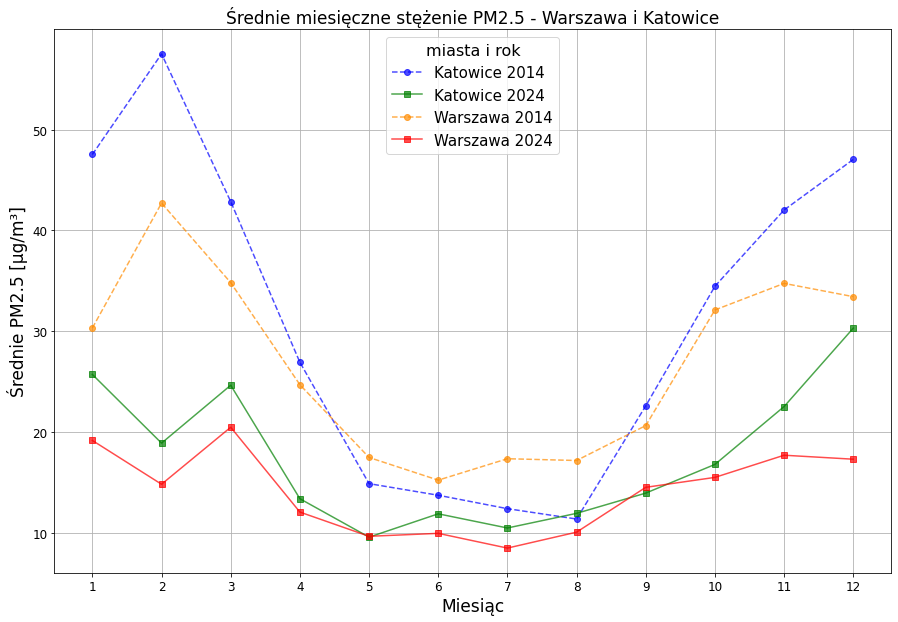

In [41]:
plt.figure(figsize=(15,10))


for i in range(len(data_to_plot)):
    data_to_plot[i].astype(float).plot(label=names_to_plot[i], marker=markers[i], linestyle=linestyles[i], color=colors[i],alpha=0.7)
    
plt.xticks(range(1, 13), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Miesiąc', fontsize=17)
plt.ylabel('Średnie PM2.5 [µg/m³]', fontsize=17)
plt.legend(fontsize=15, title="miasta i rok", title_fontsize=16, loc = 'upper center')
plt.title('Średnie miesięczne stężenie PM2.5 - Warszawa i Katowice', fontsize=17)
plt.grid()
plt.show()

### Wnioski:

Wykres liniowy przedstawia zmiany średniego miesięcznego stężenia pyłu zawieszonego PM2.5 (w mikrogramach na metr sześcienny, µg/m³) w ciągu roku dla dwóch miast: Warszawy i Katowic. Dla każdego z miast porównane są dwa lata: 2014 (linia przerywana) i 2024 (linia ciągła).

Oś pozioma (X): Przedstawia miesiące roku, od stycznia (1) do grudnia (12).
Oś pionowa (Y): Przedstawia średnie stężenie PM2.5 w µg/m³.

Linie niebieska i zielona: reprezentują Katowice w odpowiednio 2014 i 2024 roku 

Linie pomarańczowa i czerwona: Reprezentują Warszawę odpowiednio w 2014 i 2024 roku 

Możemy zauważyć, że w roku 2014 zarówno w Katowicach jak i w Warszawie stężenie PM2.5 było większe niż w roku 2024. Na wykresie widać również, że to stężenie jest większe w miesiącach zimowych, a mniejsze w letnich. Zimą w Katowicach wartości PM2.5 są wyższe niż w Warszawie - może tak być ze względu na ogrzewanie i przemysł.

## Zadanie 3

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

In [42]:
# najpierw musimy przygotować dane do heatmapy - uśrednić wartości po wszystkich stacjach w danej miejscowości

miejscowosci = srednia_miesieczna.columns.get_level_values(1).unique()

heatmap_data = []

for miasto in miejscowosci:
    cols = [col for col in srednia_miesieczna.columns if col[1]==miasto] # wybieramy wszystkie stacje z danego miasta
    df_miasto = srednia_miesieczna[cols].mean(axis=1) # średnia ze wszystkich stacji w danym mieście dla danego miesiąca
    df_dane = pd.DataFrame({"rok": df_miasto.index.year, "miesiac": df_miasto.index.month, "miejscowosc": miasto, "pm25": df_miasto.values })
    heatmap_data.append(df_dane)

df_heatmap = pd.concat(heatmap_data, ignore_index=True)

df_heatmap

,rok,miesiac,miejscowosc,pm25
0,2014,1,Wrocław,42.797037
1,2014,2,Wrocław,38.649351
2,2014,3,Wrocław,36.125
3,2014,4,Wrocław,25.353659
4,2014,5,Wrocław,14.963925
...,...,...,...,...
2767,2024,8,Szczecin,10.787634
2768,2024,9,Szczecin,15.462357
2769,2024,10,Szczecin,13.072394
2770,2024,11,Szczecin,10.940833


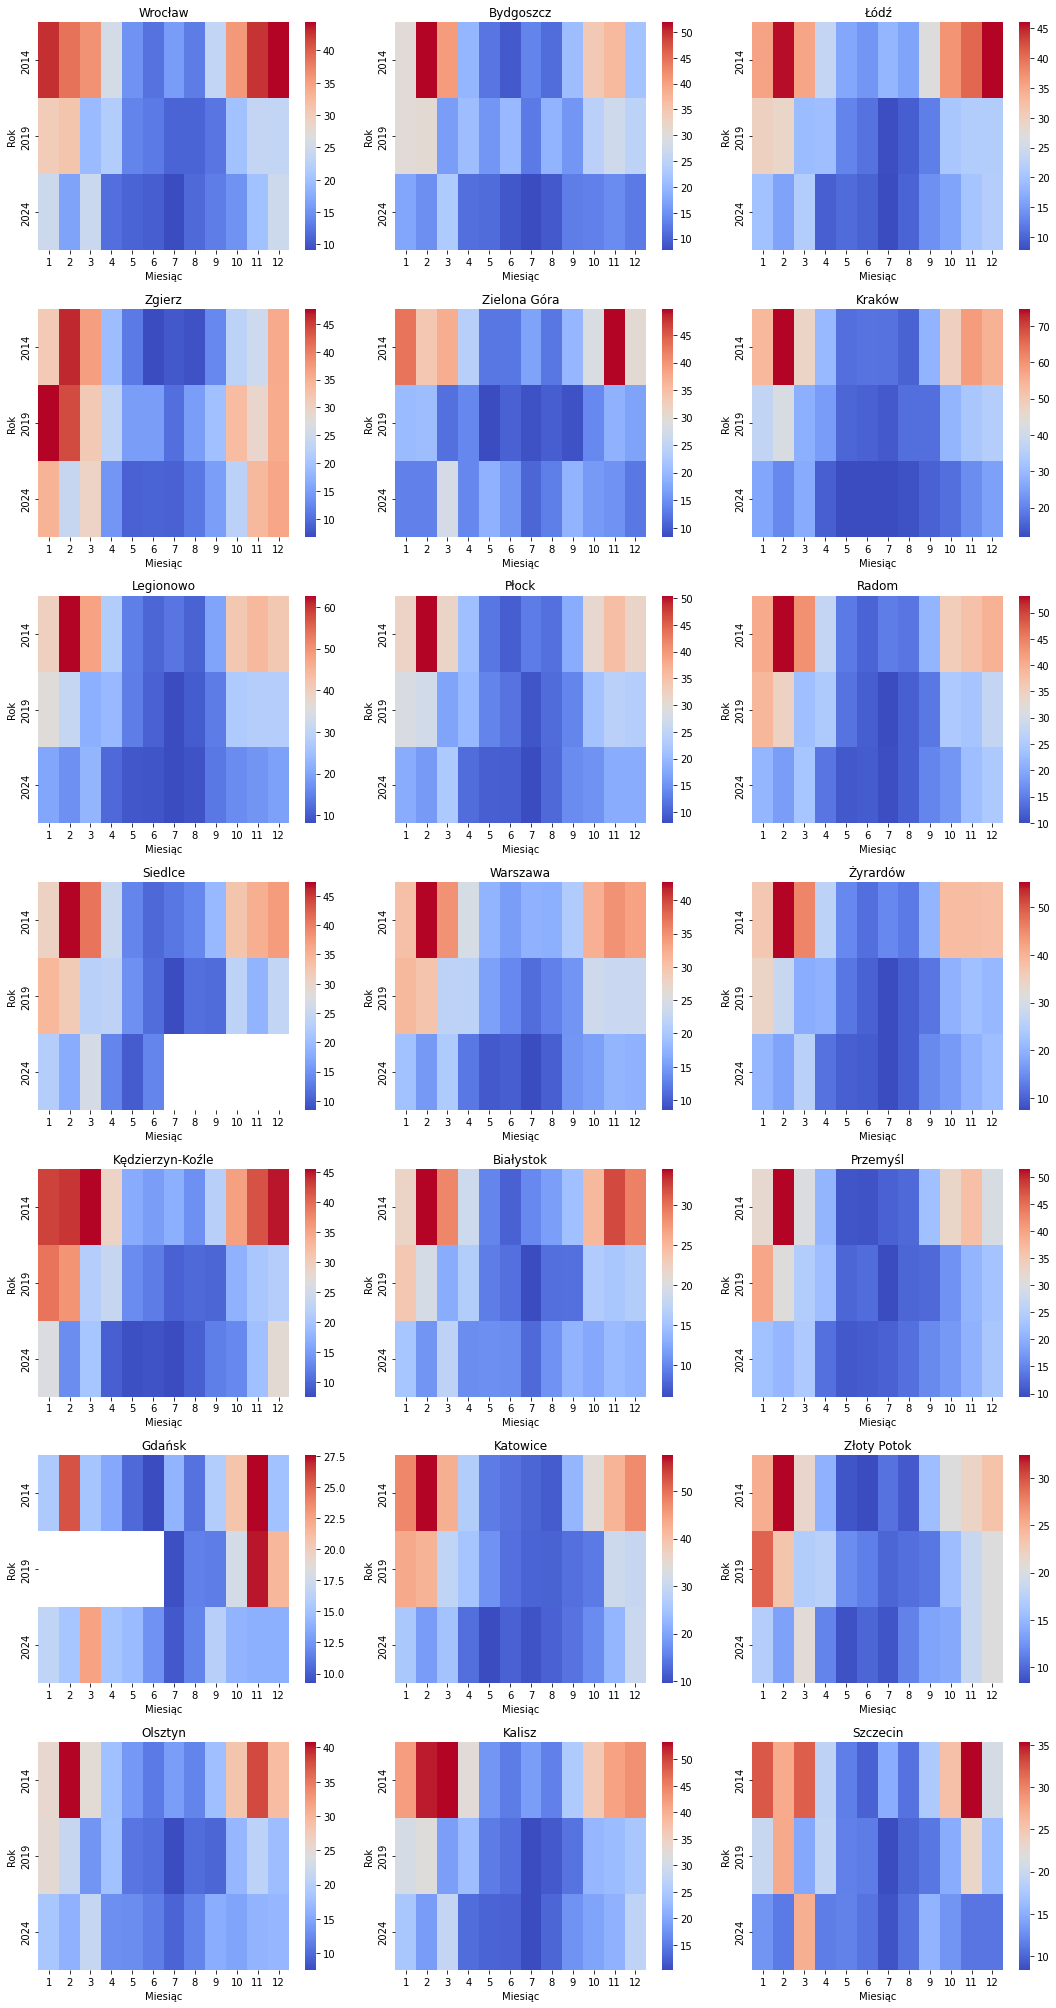

In [43]:
# rysujemy wykresy

df_heatmap_filtered = df_heatmap[df_heatmap['rok'].isin([2014, 2019, 2024])] # wybieramy tylko te lata które nas inetersują - tworzymy osobny pomocniczy dataframe

# lista miejscowości
miejscowosci = df_heatmap_filtered['miejscowosc'].unique()

# tworzymy tyle paneli (heatmap) ile miejscowości

# chcemy ustawić panele 
kolumny = 3
if len(miejscowosci)%kolumny == 0:
    wiersze = len(miejscowosci)//kolumny
else:
    wiersze = len(miejscowosci)//kolumny +1

wykres, mniejsze_wykresy = plt.subplots(wiersze, kolumny, figsize=(kolumny*5, wiersze*4))

mniejsze_wykresy=mniejsze_wykresy.flatten() # tutaj zmieniamy dwuwymiarowy wektor na jednowymiarową listę paneli, dzięki temu zip(mniejsze_wykresy, miejscowosci) w następnym kroku działa poprawnie

for panel, miasto in zip(mniejsze_wykresy, miejscowosci): # tutaj w tej pętli łączymy elementy dwóch list parami: subplot1-miejscowosc1, subplot2-miejscowosc2 itd.
    df_miasto = df_heatmap_filtered[df_heatmap_filtered['miejscowosc'] == miasto] # filtrujemy wiersze tylko dla aktualnego miasta
    pivot = df_miasto.pivot(index='rok', columns='miesiac', values='pm25').astype(float) # zmieniamy za pomocą pivot() format tabeli - odpowiedni do heamapy - z long na wide (miesiące w kolumnach)

    sns.heatmap(pivot, ax=panel, cmap='coolwarm', cbar=True) # do narysowania wykresów uzywam biblioteki seaborn
    panel.set_title(miasto)
    panel.set_xlabel("Miesiąc")
    panel.set_ylabel("Rok")

plt.tight_layout() # zeby wykresy na siebie nie nachodziły
plt.show()

### Wnioski:
Patrząc na wszystkie wykresy razem widzimy, że najwięcej koloru czerwonego jest w wierszach z rokiem 2014. Najwyższe stężenia PM2.5 można zauważyć np. w miastach Kędzierzyn Koźle czy Wrocław (południe Polski). Podobnie jak w zadaniu 2 - najwyższe wartości są odnotowane w miesiącach zimowych. 

## Zadanie 4

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

In [44]:
# najpierw tworzymy nowy dataframe który zliczy nam ilość dni w którym przekroczono dobową normę stęzenia
 
df= combined_df.copy()
df['Rok'] = df.index.year
df['Dzień'] = df.index.day

dobowe = df.groupby(['Rok','Dzień']).mean()
przekroczenia = (dobowe>15)

wynik = przekroczenia.groupby('Rok').sum()

wynik


Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,...,OpKKozBSmial,PdBialUpalna,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,...,Kędzierzyn-Koźle,Białystok,Przemyśl,Gdańsk,Katowice,Złoty Potok,Olsztyn,Kalisz,Szczecin,Szczecin
Rok,,,,,,,,,,,,,,,,,,,,,
2014,31,31,31,27,31,31,31,31,31,31,...,31,29,31,20,31,22,30,31,27,31
2019,26,30,28,31,9,31,31,31,30,31,...,28,5,31,17,31,22,15,30,9,23
2024,16,4,13,31,20,29,24,7,9,27,...,10,0,24,14,29,10,13,28,3,11


In [45]:
# szukamy 3 stacje z najmniejszą i 3 z największą liczbą dni z przekroczeniem normy w 2024 roku

rok_2024 = wynik.loc[2024]
rok_2024_sorted = rok_2024.sort_values(ascending=False)

df_2024_sorted = rok_2024_sorted.to_frame(name='wartość')

df_najwiecej = df_2024_sorted.head(3)
df_najmniej = df_2024_sorted.tail(3)


stacje = df_najwiecej.index
stacje = list(stacje.append(df_najmniej.index))

df_final = wynik[stacje]


df_final

Kod stacji,LdZgieMielcz,MpKrakAlKras,SlKatoKossut,MzWarWokalna,ZpSzczAndrze,PdBialUpalna
Miejscowość,Zgierz,Kraków,Katowice,Warszawa,Szczecin,Białystok
Rok,,,,,,
2014,27,31,31,31,27,29
2019,31,31,31,22,9,5
2024,31,29,29,3,3,0


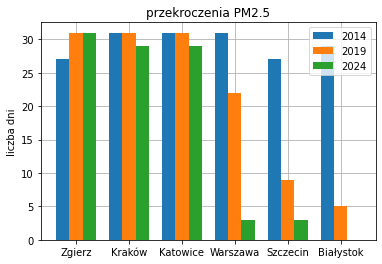

In [46]:
# wybieramy tylko miejscowości
miasta = list(df_final.columns.get_level_values(1))


a = len(miasta)
x = np.arange(a)

width = 0.25

plt.bar(x-width, df_final.loc[2014], width, label="2014")
plt.bar(x,df_final.loc[2019], width, label="2019")
plt.bar(x+width, df_final.loc[2024], width, label="2024")

plt.xticks(x, miasta) # ustawienia etykiet a osi x wykresu - ustawia w miejscach x i podpisuje nazwą miasta 
plt.legend()
plt.ylabel("liczba dni")
plt.title("przekroczenia PM2.5")
plt.grid()
plt.gca().set_axisbelow(True) #ustawiamy to aby linie siatki byly z tylu wykresu i niczego nie zasłaniały
plt.show()

### Wnioski:
Na wykresie widzimy, że znacznie więcej dni z przekroczeniem stężenia PM2.5 było w roku 2014. W 2019 troszkę się to poprawiło, ale jednak największą zmianę widać w roku 2024. Największą poprawę na przestrzeni lat możemy zauważyć w Warszawie czy Białymstoku, a najmniejszą w Krakowie i Katowicach. 